In [1]:
# 1D Core Interior Model

'''Interior Structure Evolution Modell of an Iron rich Core in a Teresstrial Planet created by Louis Müller (20.05.2024)'''

'Interior Structure Evolution Modell of an Iron rich Core in a Teresstrial Planet created by Louis Müller (20.05.2024)'

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [3]:

names = ['g', 'P', 'rho', 'r', 'T', 'Tm', 'Cp', 'alpha', 'gamma', 'Kt', 'Ka', 'G', 'sigma', 'phase']

titles =  [
    'Gravity', 'Pressure', 'Density', 'Temperature', 'Melt Temperature', 'Heat Capacity',
    'Thermal Expansivity', 'Grüneisen Parameter', 'Isothermal Bulk Modulus', 
    'Adiabatic Bulk Modulus', 'Shear Modulus', 'Electrical Conductivity', 'Material Phase Number'
]

profs = [
    'M1_Fe30_sFe6-5_pprofs.res', 'M1_Fe60_sFe6-5_pprofs.res', 'M2_Fe30_sFe6-5_pprofs.res',
    'M2_Fe60_sFe6-5_pprofs.res', 'M3_Fe30_sFe6-5_pprofs.res', 'M3_Fe60_sFe6-5_pprofs.res',
    'M4_Fe30_sFe6-5_pprofs.res', 'M4_Fe60_sFe6-5_pprofs.res', 'M5_Fe30_sFe6-5_pprofs.res',
    'M5_Fe60_sFe6-5_pprofs.res'
]

lbl = [r'1 M  30% Fe', r'1 M  60% Fe', r'2 M  30% Fe', r'2 M  60% Fe', r'3 M  30% Fe',
    r'3 M  60% Fe', r'4 M  30% Fe', r'4 M  60% Fe', r'5 M  30% Fe', r'5 M  60% Fe'
       ]

#clrs= np.array([[255, 195, 0], [255, 87, 51], [199, 0, 57], [144, 12, 63], [88, 24, 69]]) / 255

#nrColors = len(foldernames)
nrColors = 5

cmap = mpl.colormaps['viridis_r']
clrs = cmap(np.linspace(0,1,nrColors))

# from profs.res load the data as a dataframe with 14 columns that are delimitered by whitespace
planets = {}
labels = {}
for prof in profs:
    df = pd.read_csv(prof,delimiter=r'\s+', names=names)
    for i in range(len(df['phase'])):
        if df['phase'][i] == 8.0:
            cmb = i
            # delete all values after index cmb
            break
    df = df.drop(df.index[:cmb])
    i = profs.index(prof)
    # convert the index from 0 to 511
    ncmb = 1000-cmb
    df.index = range(0,ncmb)
    reverse = df[::-1]

    # corrections
    df['n'] = ncmb
    df['r'] = df['r']-df['r'][ncmb-1]
    df['P'] = df['P']*1.0e9
    df['alpha'] = df['alpha']*1.0e5
    prof = prof[0:6]
    planets[prof] = df
    labels[prof] = lbl[i]


In [4]:
# Alfe et al. 2002 50 - 350 GPa

# Sixtrude Silicate liquidus curve 2014
def T_ms2014(P, x_light=0):
    T_ms = 5400 * (P*1e-9 / 140)**0.480 / (1 - np.log(1 - x_light))
    return T_ms

# Stevenson et al. 1983 
# Todo: find out span of P in model 
def T_m1983(P, x_light=0): 
    Tm0 = 2060              # Tm0 [K], Tm1 [K TPa^-1], Tm2 [K TPa1-2] are factors of the quadradic Pressure 
    Tm1 = 6.14*1e-12        # dependent liq. function (Stacey 1977b) (values for Earth with x = 0.1)
    Tm2 = -4.5*1e-24   
    ac = 0.1                # light element correction factor
    T_melt = Tm0 * (1 - ac * x_light) * (1 + Tm1 * P + Tm2 * P**2) 
    return T_melt

# Sixtrude 2014 based on Morard et al. 2011 with possible light element correction
def T_m2014(P, x_light=0): 
    T_melt = 6500 * (P*1e-9 / 340)**0.515 * 1 / (1 - np.log(1 - x_light))
    return T_melt

# ab initio Li et al. 2020 120 - 256 GPa
def T_m2020(P): 
    T_melt = 4242 * ( (P - 120.6)/98 + 1)**(1/3.35)
    return T_melt

# ab initio by Kraus et al. 2022
# lasers and in situ x-ray diffraction for 260 - 1000 GPa (hcp)structure.
def T_m2022(P): 
    T_melt = 5530 * ((P - 260)/293 + 1)**0.552
    return T_melt
    
# ab initio by Gonzalez-Cataldo et al. 2023
# 300 - 5000 GPa
def T_m2023(P): 
    T_melt = 6469 * (1 + (P*1e-9 - 300)/434.82)**0.54369
    return T_melt

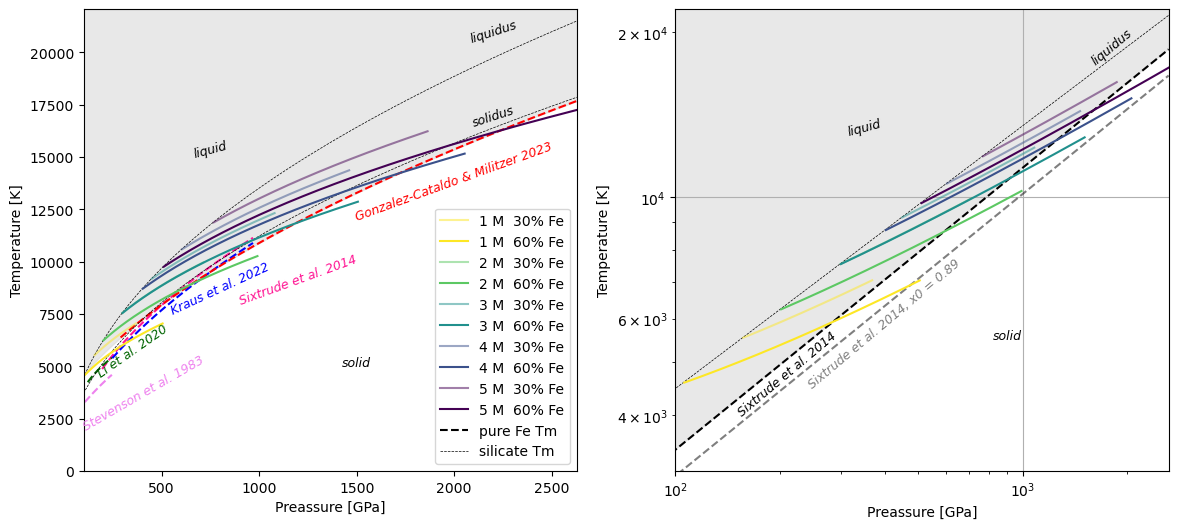

In [8]:
fig, ax = plt.subplots(1,2,figsize=(14, 6))

n = planets['M5_Fe6']['n'][0]
P = np.linspace(0, planets['M5_Fe6']['P'][n-1], 1000)
a = [20, 20, 30, 55, 35, 18]
i = 650
b = 1
l = 1.5 # linewidth
X_M0 = 0.11
XFeM = 0.1
ls = 'dashed'

if T_m2014(P)[999] > T_m2023(P)[999] and T_m2014(P)[999] > T_ms2014(P)[999]:
    max_fill = T_m2014(P)[999]
elif T_m2023(P)[999] > T_m2014(P)[999] and T_m2023(P)[999] > T_ms2014(P)[999]: 
    max_fill = T_m2023(P)[999]
else:
    max_fill = T_ms2014(P)[999]

# 0:94 Stevenson et al. 1983
ax[0].plot(P[0:94]*1.0e-9, T_m1983(P[0:94]), color = 'violet', linestyle=ls, linewidth=l, alpha=b)
ax[0].text(410, 2000, 'Stevenson et al. 1983', horizontalalignment='center', fontsize=9, color='violet', fontstyle='italic', rotation=a[2])

# 74:368 Sixtrude et al. 2014
ax[0].plot(P[74:369]*1.0e-9, T_m2014(P[74:369]), color = 'deeppink', linestyle=ls, linewidth=l, alpha=b)
ax[1].plot(P*1.0e-9, T_m2014(P), color = 'black', linestyle=ls, linewidth=l, alpha=b)
ax[1].plot(P*1.0e-9, T_m2014(P,x_light=0.11), color = 'black', linestyle=ls, linewidth=l, alpha=0.5)
ax[0].text(1200, 8000, 'Sixtrude et al. 2014', horizontalalignment='center', fontsize=9, color='deeppink', fontstyle='italic', rotation=a[1])

# 46:94 Li et al. 2020
ax[0].plot(P[46:94]*1.0e-9, T_m2020(P[46:94]*1.0e-9), color = 'darkgreen', linestyle=ls, linewidth=l, alpha=b)
ax[0].text(350, 4500, 'Li et al. 2020', horizontalalignment='center', fontsize=9, color='darkgreen', fontstyle='italic', rotation=35)

# 94:369 Kraus et al. 2022
ax[0].plot(P[94:369]*1.0e-9, T_m2022(P[94:369]*1.0e-9), color = 'blue', linestyle=ls, linewidth=l, alpha=b)
ax[0].text(800, 7500, 'Kraus et al. 2022', horizontalalignment='center', fontsize=9, color='blue', fontstyle='italic', rotation=25)

# 110:1000 Gonzalez-Cataldo et al. 2023
ax[0].plot(P[110:]*1.0e-9, T_m2023(P[110:]), color = 'red', linestyle=ls, linewidth=l, alpha=b)
ax[0].text(2000, 12000, 'Gonzalez-Cataldo & Militzer 2023', horizontalalignment='center', fontsize=9, color='red', fontstyle='italic', rotation=a[0])

# silicate solidus curve
ax[0].plot(P*1.0e-9, T_ms2014(P,x_light=X_M0+XFeM), linestyle = ls, color = 'black', linewidth=0.5)
ax[0].plot(P*1.0e-9, T_ms2014(P,x_light=0.0+0.026), linestyle = ls, color = 'black', linewidth=0.5)
ax[1].plot(P*1.0e-9, T_ms2014(P,x_light=0.0+0.026), linestyle = ls, color = 'black', linewidth=0.5)
ax[0].text(2200, 20500, 'liquidus', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=a[5])
ax[1].text(1800, 17500, 'liquidus', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=40)
ax[0].text(2200, 16500, 'solidus', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=a[5])

for prof in profs:
    i = profs.index(prof)
    prof = prof[0:6]
    if i % 2 == 0:
        op = 0.5
    else:
        op = 1
    ax[0].plot(planets[prof]['P']*1.0e-9, planets[prof]['T'], color = clrs[i//2], alpha = op, label = labels[prof])
    ax[1].plot(planets[prof]['P']*1.0e-9, planets[prof]['T'], color = clrs[i//2], alpha = op, label = labels[prof])

ax[0].plot(0,0, color = 'black', linestyle = ls, linewidth=l, alpha = b, label = 'pure Fe Tm')
ax[0].plot(0,0, color = 'black', linestyle = ls, linewidth=0.5, label = 'silicate Tm')
ax[0].text(750, 15000, 'liquid', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=15)
ax[0].text(1500, 5000, 'solid', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=0)
ax[0].fill_between(P*1.0e-9, T_m2023(P), max_fill, where=(T_m2023(P) < max_fill), interpolate=True, color='lightgray', alpha=0.5)
#ax[0].set_title('Comparisson of Silicate and Iron Melt Temperatures in Super Earths')
ax[0].set_xlabel('Preassure [GPa]')
ax[0].set_ylabel('Temperature [K]')
ax[0].set_xlim(1e2,P[999]*1.0e-9)
ax[0].grid(False)
ax[0].margins(x=0, y=0)  # Set x and y margins to 0
ax[0].legend()

ax[1].fill_between(P*1.0e-9, T_m2014(P), max_fill, where=(T_m2014(P) < max_fill), interpolate=True, color='lightgray', alpha=0.5)
ax[1].text(210, 4000, 'Sixtrude et al. 2014', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=40)
ax[1].text(400, 4500, 'Sixtrude et al. 2014, x0 = 0.89', horizontalalignment='center', fontsize=9, color='gray', fontstyle='italic', rotation=40)
ax[1].text(350, 13000, 'liquid', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=15)
ax[1].text(900, 5500, 'solid', horizontalalignment='center', fontsize=9, color='black', fontstyle='italic', rotation=0)
ax[1].set_xlabel('Preassure [GPa]')
ax[1].set_ylabel('Temperature [K]')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(1e2,P[999]*1.0e-9)
ax[1].set_ylim(10**3.5,max_fill)
ax[1].grid(True)

plt.savefig('MeltTemp.svg')

-0.2613647641344075
